<a href="https://colab.research.google.com/github/GabrielCostaDeOliveira/faceDetectionTraining/blob/main/faceDetectionDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from fastai.vision.all import *
import numpy as np

# Treino

Definindo o `path` para o dataset.

In [2]:
path = Path(os.path.join(os.getcwd(), '..', 'dataset')) # Pega o path onde o python será executado, volta e seleciona o dataset
Path.BASE_PATH = path # Muda a raiz do path para o dataset
path.ls()

(#3) [Path('wider_face_split'),Path('WIDER_train'),Path('WIDER_val')]

Verificando se as imagens não foram corrompidas

In [3]:
images = get_image_files(path) # retorna todos os caminho de imagens

Eliminando as imagens que falharam

In [4]:
# failed = verify_images(images) # retorna os caminho para imagens com falhas
# print(failed)
# failed.map(Path.unlink) # Para cada caminho, exclui o arquivo associado

Definindo funções auxiliares para recuperar as anotações das imagens dado seu _path_
Variáveis dependentes dos dados

In [5]:
# Retorna o caminho dentro da pasta annotations para as anotações de cada imagem
# caminho retira o formato da imagem (.jpg)
#
#
# Ex de path:
# /home/adriansl/unb/2022_1/ml/faceDetectionTraining/dataset/WIDER_val/images/0--Parade/0_Parade_marchingband_1_20.jpg
# split = [
#   '/home/adriansl/unb/2022_1/ml/faceDetectionTraining/dataset/WIDER_val/',
#   '/0--Parade/0_Parade_marchingband_1_20.jpg'
# ]
def img2bbox_path(path: Path):
    return 'annotations'.join(str(path).rsplit('images', 1))[:-4] # split pela direita

# Retorna um array numpy com n linhas dos dados de cada rosto
# [`left`, `top`, `width`, `height`].
# lê os dados dos arquivos annotations gerados pelo script 
# create_annotations.py (executado antes do notebook)
def get_annotation_values(path: Path):
    # with lida com tratamento de exceções e garbage collection
    # de forma padronizada pelo próprio objeto
    # Utiliza fases de execuçaçao
    with open(img2bbox_path(path), 'r', encoding='utf-8') as f:
        # para cada linha do annotation daquela imagem, 
        # cria uma lista com os dados
        #
        # faz split de cada inteiro da linha
        # operador * faz o spreading (separação) dos itens do map
        return np.array([[*map(int, s.split())] for s in f.readlines()])

Função para recuperar a bounding box de uma imagem dado seu caminho

**Recupera** somente os 4 primeiros valores (bounding box )
**[`left`, `top`, `width`, `height`].**

In [6]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return ctr[:,:4]
    return []

Visualizando um exemplo de imagem com sua bounding box

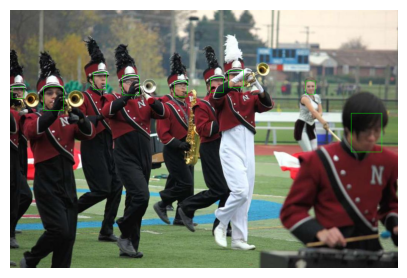

In [7]:
img = plt.imread(images[0]).copy()
for x,y,w,h in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y,x:x+w] = color
    img[y:y+h,x] = color
    img[y+h,x:x+w] = color
    img[y:y+h,x+w] = color
show_image(img);

A fastai espera a bounding box no formato [`left`, `top`, `right`, `bottom`].

Porém o nosso dataset utiliza no formato [`left`, `top`, `width`, `height`].

Então precisamos converter a bounding box para o formato da fastai. Para isso vamos alterar a função `get_bbox` definida anteriormente.

In [8]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [[x, y, x + w - 1, y + h - 1] for x, y, w, h in ctr[:,:4]]
    return []

apresentando a mesma imagem com o novo formato da bounding box

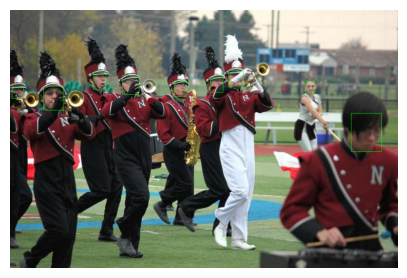

In [9]:
img = plt.imread(images[0]).copy()
for x1,y1,x2,y2 in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y1,x1:x2] = color
    img[y1:y2,x1] = color
    img[y2,x1:x2] = color
    img[y1:y2,x2] = color
show_image(img);

Função para recuperar os labels de uma imagem dado seu _path_
Label além do boundind box, verifica se a face tem algum tipo de obstrução.

In [10]:
# vocab = ['no occlusion', 'partial occlusion', 'heavy occlusion']
vocab = ['\n', '\t', '\r']

In [11]:
def get_label(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [vocab[x] for x in ctr[:,-2]]
    return []

In [12]:
def custom_get_image_files(o):return list(filter(get_label, get_image_files(o)))
images = custom_get_image_files(path)[:320]

In [13]:
data_block = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock()),
    get_items=lambda o: images,
    # noop == no-operation, já que ImageBlock já retorna a imagem do caminho para o batch
    # utilizanfo PILBase.create
    # funcções separadas para as variáveis dependentes do BBox e para as labels
    getters=[noop, get_bbox, get_label],
    # Como o dado já está separado em validação, a função verifica se 
    # o caminho ../../../nome_da_pasta termina com 'val':
    # splitter=FuncSplitter(lambda o: o.parent.parent.parent.name.endswith('val')),
    item_tfms=Resize(224, method='squish'),
    batch_tfms=[*aug_transforms(min_scale=1.0), Normalize.from_stats(*imagenet_stats)],
    n_inp=1
)
# Testes iniciais com o datablock
#data_block.summary(path)

Como podemos ver, nosso dataset é possui `12880` itens para treino e `3226` para validação.

In [14]:
datasets = data_block.datasets(path)

len(datasets.train), len(datasets.valid)

(256, 64)

Onde cada item é composto por uma imagem (a variável independente), uma tensor de bounding boxes e um tensor de multi categorias (que juntos compõem as variáveis dependentes).

In [15]:
datasets.train[0]

(PILImage mode=RGB size=1024x683,
 TensorBBox([[ 870.,  295.,  881.,  309.],
             [ 846.,  283.,  857.,  300.],
             [ 808.,  290.,  821.,  310.],
             [ 788.,  292.,  795.,  302.],
             [ 948.,  280.,  961.,  297.],
             [ 928.,  298.,  939.,  312.],
             [ 971.,  297.,  980.,  307.],
             [1009.,  294., 1018.,  309.],
             [ 914.,  291.,  920.,  300.],
             [ 726.,  297.,  734.,  308.],
             [ 665.,  293.,  695.,  331.],
             [ 695.,  300.,  712.,  326.],
             [ 633.,  290.,  643.,  307.],
             [ 759.,  293.,  765.,  299.],
             [ 586.,  268.,  606.,  294.],
             [ 552.,  305.,  580.,  338.],
             [ 486.,  267.,  520.,  312.],
             [ 452.,  268.,  477.,  294.],
             [ 364.,  277.,  393.,  311.],
             [ 294.,  276.,  318.,  306.],
             [ 549.,  285.,  556.,  292.],
             [ 519.,  286.,  525.,  296.],
             [ 181.,

In [16]:
data_loaders = data_block.dataloaders(path, bs=128)
data_loaders.vocab

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


['#na#', '\t', '\n', '\r']

c:\Users\Thalisson\prog\aulas\ml\.venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
) missing from current font.s\ml\.venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
c:\Users\Thalisson\prog\aulas\ml\.venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
) missing from current font.s\ml\.venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


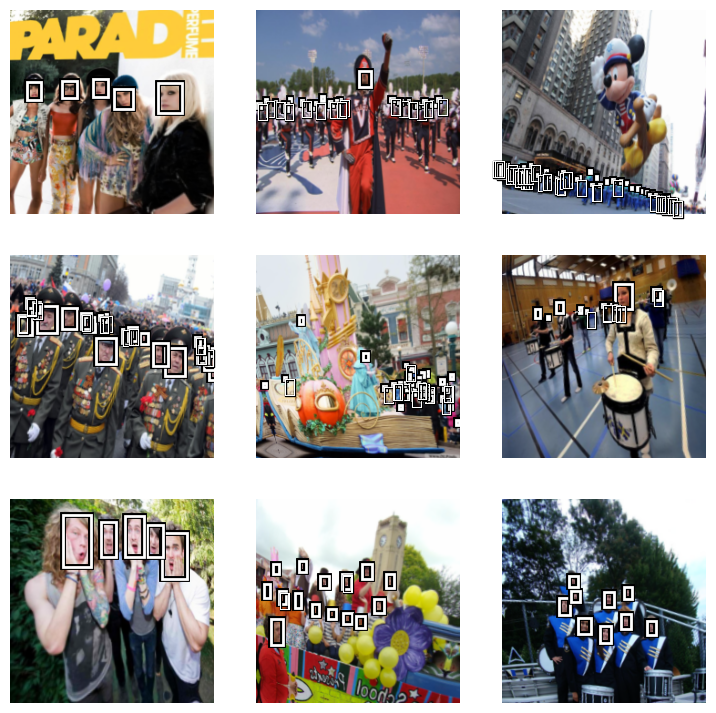

In [17]:
data_loaders.show_batch()

As coordenadas das bounding boxes são re-escaladas para valores entre -1 e 1

In [18]:
one_batch = data_loaders.one_batch()
one_batch[1][0][0]

TensorBBox([ 0.1973, -0.0760,  0.3665,  0.2227], device='cuda:0')

In [19]:
len(one_batch[2][0])

405

In [20]:
def flatten_conv(x,k):
    # Flatten the 4x4 grid to dim16 vectors
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    # Output Layers for SSD-Head. Contains oconv1 for Classification and oconv2 for Detection
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(data_loaders.vocab))*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

class StdConv(nn.Module):
    # Standard Convolutional layers 
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)


In [21]:
head_reg4 = SSD_Head(1, -3.)
body = create_body(resnet34(True))
model = nn.Sequential(body, head_reg4)

c:\Users\Thalisson\prog\aulas\ml\.venv\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\Thalisson\prog\aulas\ml\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
out0 = body(one_batch[0].cpu())
out1 = head_reg4(out0)
out1[0].shape, out1[1].shape

(torch.Size([128, 16, 4]), torch.Size([128, 16, 4]))

In [23]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels].cuda()

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ.squeeze(), self.num_classes)
        t = t[:,1:] # Start from 1 to exclude the Background
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w.detach(), reduction='sum')/self.num_classes
    
    def get_weight(self,x,t): return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [24]:
loss_f = FocalLoss(len(data_loaders.vocab))

In [25]:
anc_grid = 4 # Start with only 4x4 grid and no variation for each cell
k = 1 # Variation of each anchor box
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid) # Center of anc in x
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid) # Center f anc in y

anc_x, anc_y

(array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625,
        0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875]),
 array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125,
        0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875]))

In [26]:
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1)) # Anchor centers
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

anc_ctrs, anc_sizes

(array([[0.125, 0.125],
        [0.125, 0.375],
        [0.125, 0.625],
        [0.125, 0.875],
        [0.375, 0.125],
        [0.375, 0.375],
        [0.375, 0.625],
        [0.375, 0.875],
        [0.625, 0.125],
        [0.625, 0.375],
        [0.625, 0.625],
        [0.625, 0.875],
        [0.875, 0.125],
        [0.875, 0.375],
        [0.875, 0.625],
        [0.875, 0.875]]),
 array([[0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25]]))

In [27]:
anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).cuda()
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64)

In [28]:
grid_sizes = torch.tensor(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1).cuda()
grid_sizes

tensor([[0.2500]], device='cuda:0', dtype=torch.float64)

In [29]:
def get_y(bbox,clas):
    """
    Remove the zero batching from a batch
    
    Because the number of object in each image are different so
    we need to zero padding for batching 
    """
    bbox = bbox.view(-1,4)
    clas = clas.view(-1,1)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return TensorBase(bbox)[bb_keep],TensorBase(clas)[bb_keep]

In [30]:
def hw2corners(ctr, hw): 
    # Function to convert BB format: (centers and dims) -> corners
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels].cuda()

def intersect(box_a, box_b):
    """
    Intersect area between to bounding boxes
    """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """
    Jaccard or Intersection over Union
    """
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1) # 3
    gt_overlap, gt_idx = overlaps.max(0) # 16
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [31]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:]).cuda()
anchor_cnr

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]], device='cuda:0',
       dtype=torch.float64)

In [32]:
def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    bbox = (bbox+1)/2
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0  # Assign the background to idx 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((TensorBase(a_ic[TensorBase(pos_idx)]) - TensorBase(gt_bbox[TensorBase(pos_idx)])).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred, bbox, clas):
    lcs, lls = 0., 0.
    W = 30
    for b_c, b_bb, bbox, clas in zip(*pred, bbox, clas):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas)
        lls += loc_loss
        lcs += clas_loss
    return lls + lcs

In [33]:
learn = Learner(data_loaders, model, loss_func=ssd_loss)
learn.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 112 x 11 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 56 x 56  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                     

In [34]:
learn.fit_one_cycle(10, 1e-3)

In [35]:
learn.eval()

In [36]:
# learn.export()

# Inferência

In [37]:
# learn = load_learner('export.pkl')

In [38]:
# b = data_loaders.valid.one_batch()
# q, w, c = learn.get_preds(dl=[b], with_decoded=True)

In [39]:
learn.show_results()

IndexError: list index out of range

In [ ]:
def draw_bbox(img, bbox, offset=0):
    x,y,w,h = map(int, bbox)
    color = np.array([255, 0, 0], dtype=np.uint8)
    img[y-offset:y+offset,x:x+w] = color
    img[y:y+h,x-offset:x+offset] = color
    img[y+h-offset:y+h+offset,x:x+w] = color
    img[y:y+h,x+w-offset:x+w+offset] = color


In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects
import cv2

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    # ax.set_xticks(np.linspace(0, 224, 8))
    # ax.set_yticks(np.linspace(0, 224, 8))
    # ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    im = 255 * ((im + 1) / 3)
    # im = np.ascontiguousarray(im.numpy(), dtype=np.uint8)
    print(im.shape)
    k=0
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>1) and (pr is None or pr > thresh)):
            k+=1
            draw_bbox(im, b, 1)
            # draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{k}: '
            if c is not None: txt += ('bg' if c==0 else data_loaders.vocab[c])
            if pr is not None: txt += f' {pr:.2f}'
            # draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            # im = cv2.putText(im, txt, b[:2], cv2.FONT_HERSHEY_SIMPLEX, 1, (120,120,10), 1, 2)

    rotated_im = np.rot90(im, 3)
    ax = show_img(rotated_im, ax=ax)

def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

IndexError: invalid index to scalar variable.

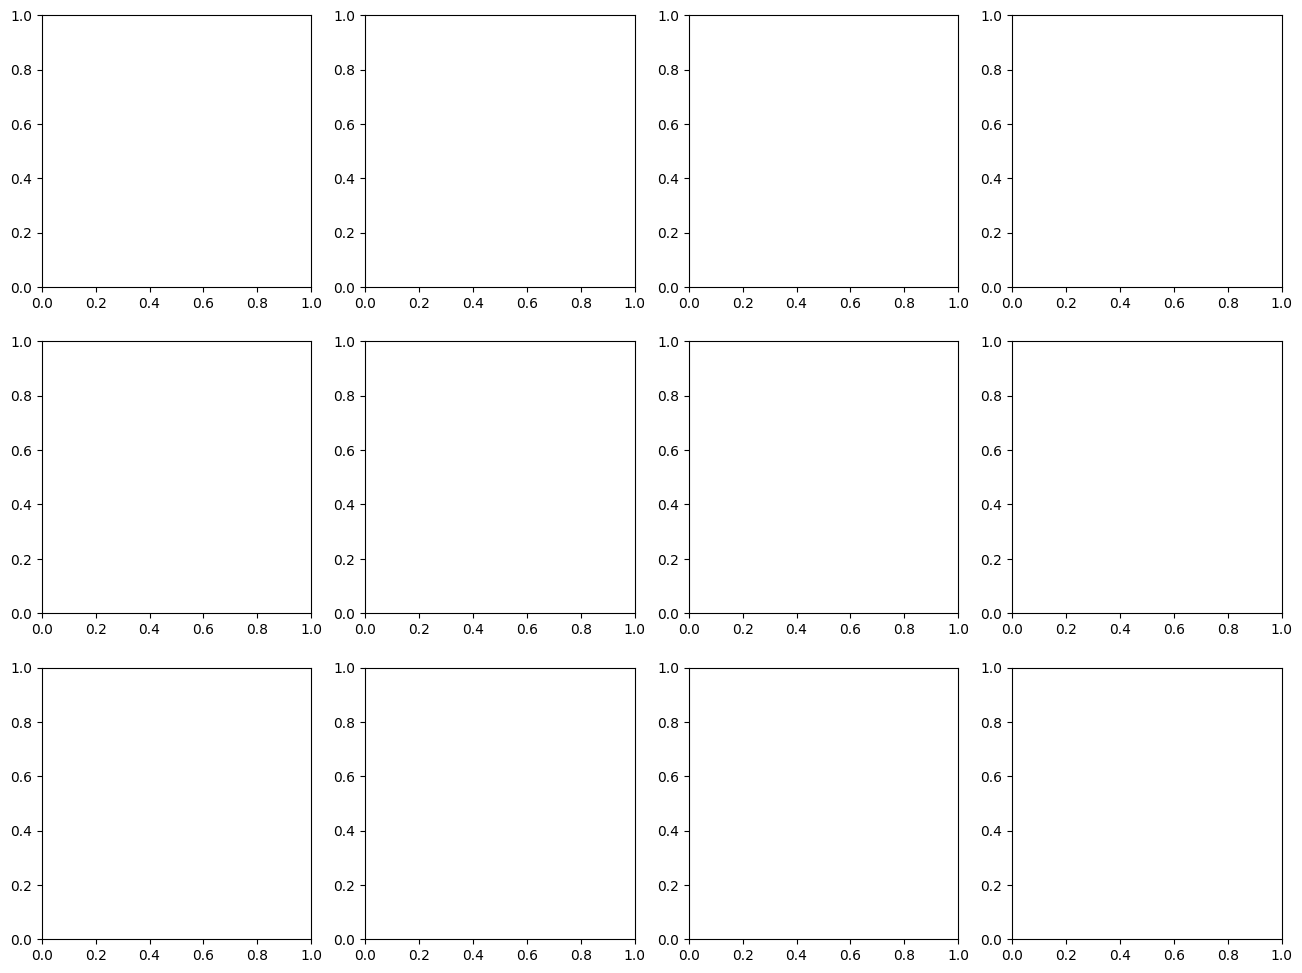

In [ ]:
one_batch = data_loaders.valid.one_batch()
learn.model.eval()
pred = learn.model(one_batch[0])
b_clas, b_bb = pred
x = one_batch[0]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima = x.permute(0,3,2,1).cpu()[idx]
#     ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), thresh=0.3)
plt.subplots_adjust(wspace=0.15, hspace=0.15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

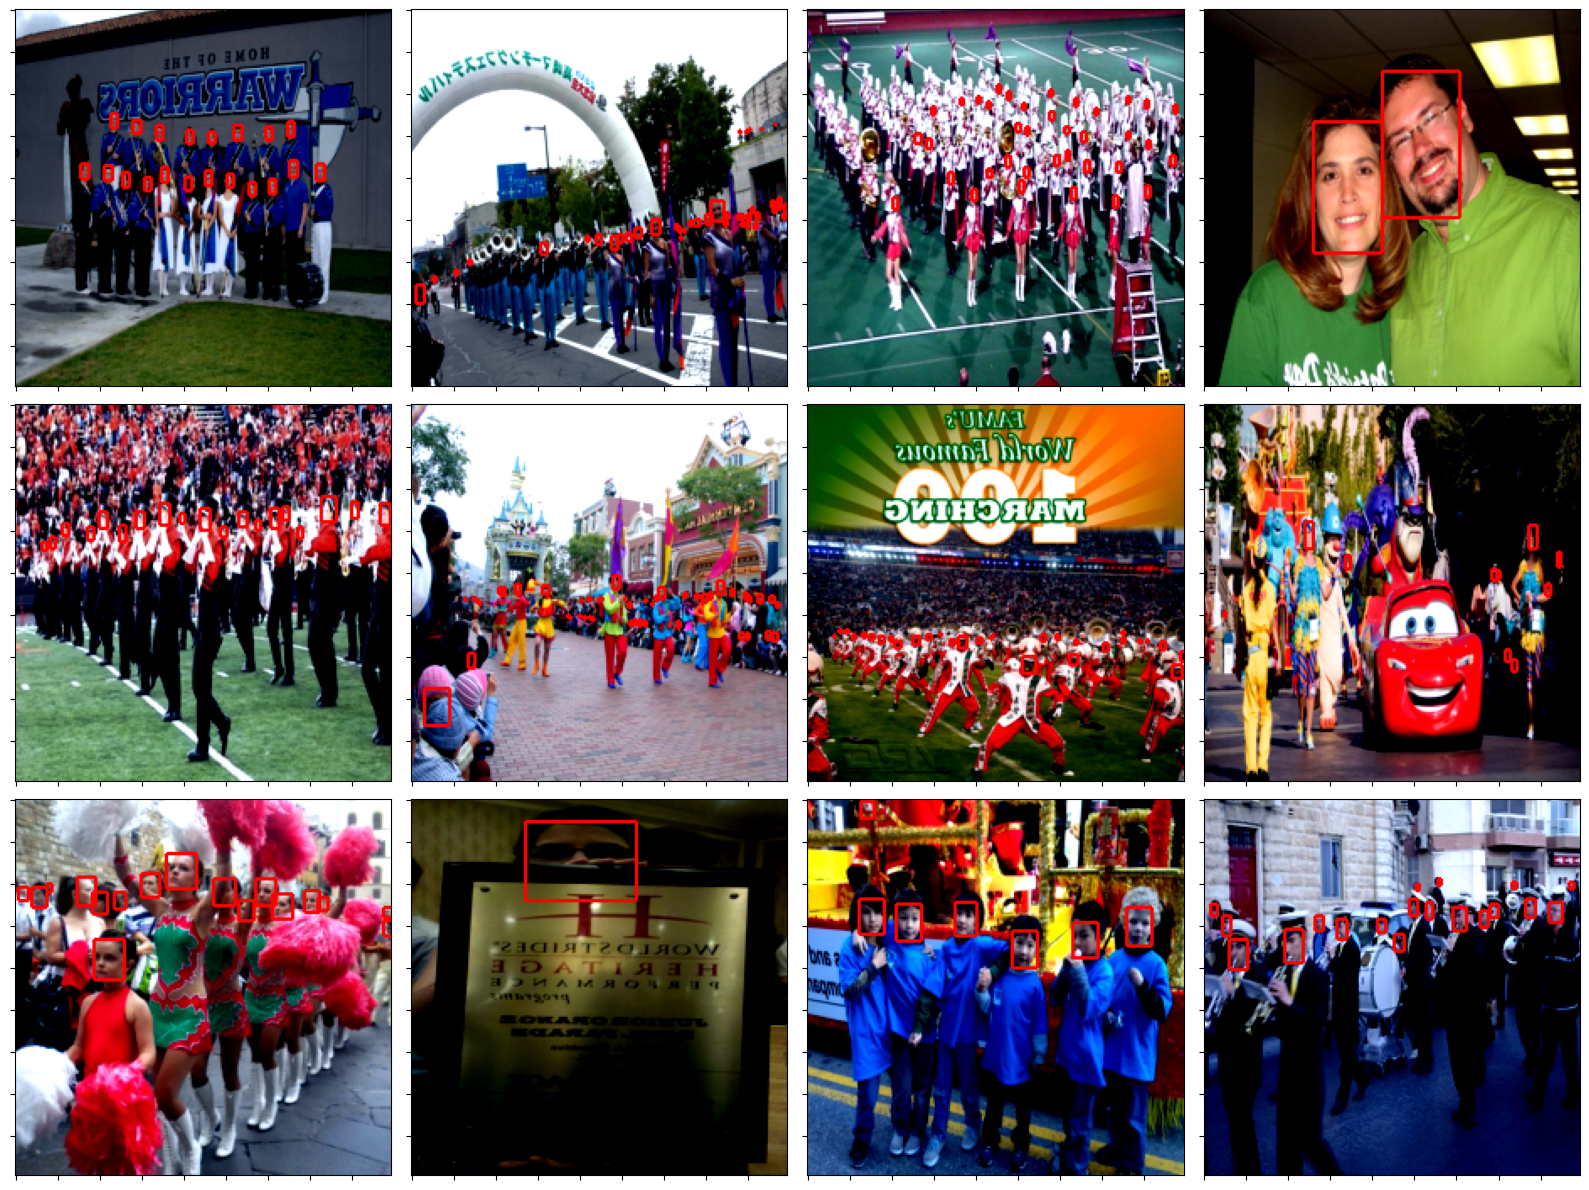

In [ ]:
one_batch = data_loaders.valid.one_batch()
y = one_batch[1:]
x = one_batch[0].permute(0,3,2,1).cpu()
## Bounding Box after dataloader should Rescale
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i].cpu(), ((y[0][i]+1)/2*224).cpu(), y[1][i].cpu())
plt.tight_layout()